In [1]:
import cv2
import os

In [2]:
# Renkli görüntülerin bulunduğu dizin
image_dir = r"C:\Software\bloodcells_dataset"

# Gri tonlamalı görüntülerin kaydedileceği dizin
grayscale_image_dir = r"C:\Software\grayscale_dataset"

# Eğer gri tonlamalı görüntü dizini yoksa oluştur
if not os.path.exists(grayscale_image_dir):
    os.makedirs(grayscale_image_dir)

# Alt dizinlerdeki görüntüleri işlemek için os.walk kullanımı
for subdir, dirs, files in os.walk(image_dir):
    for file in files:
        if file.endswith('.jpg') or file.endswith('.png'):  # Görüntü dosya uzantıları
            file_path = os.path.join(subdir, file)
            image = cv2.imread(file_path)
            if image is not None:
                # Gri tonlamalıya dönüştür
                gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

                # Gri tonlamalı görüntünün kaydedileceği alt dizini oluşturma
                relative_path = os.path.relpath(subdir, image_dir)
                output_subdir = os.path.join(grayscale_image_dir, relative_path)
                if not os.path.exists(output_subdir):
                    os.makedirs(output_subdir)

                # Gri tonlamalı görüntüyü kaydet
                gray_image_file = os.path.join(output_subdir, file)
                cv2.imwrite(gray_image_file, gray_image)


Found 17092 files belonging to 8 classes.
Using 13674 files for training.
Using 3418 files for validation.
['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']


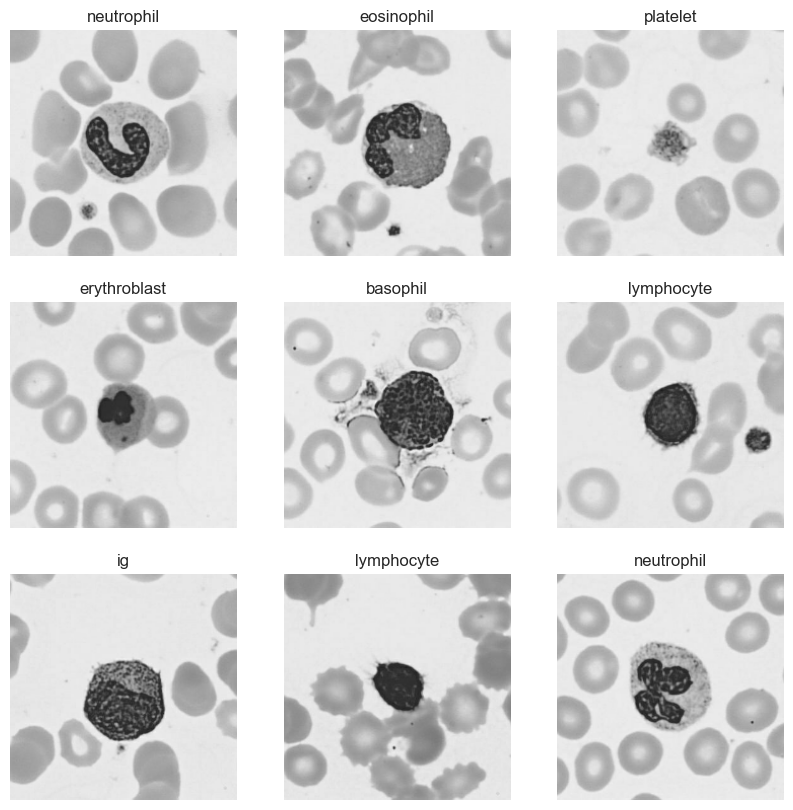

In [8]:
import seaborn as sns
from tensorflow import keras
import matplotlib.pyplot as plt
# Seaborn tema ayarı
sns.set_theme(style="ticks")

# Veri kümelerini hazırlama
grayscale_image_dir = r"C:\Software\grayscale_dataset"

BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224


grayscale_dataset, grayscale_test_dataset = keras.utils.image_dataset_from_directory(directory=grayscale_image_dir,
                                                                             image_size=(IMG_WIDTH, IMG_HEIGHT),
                                                                             batch_size=BATCH_SIZE,
                                                                             label_mode="int",
                                                                             validation_split=0.2,
                                                                             subset="both",
                                                                             shuffle=True,
                                                                             seed=42)

# Sınıf isimlerini getirme
grayscale_class_names = grayscale_dataset.class_names
print(grayscale_class_names)

# Veri kümesinden örnek görüntüler gösterme
plt.figure(figsize=(10, 10))
for images, labels in grayscale_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(grayscale_class_names[labels[i]])
        plt.axis("off")
plt.show()

In [10]:
import tensorflow as tf
# Veri kümesini eğitim ve doğrulama setine ayırma 

num_elements = len(grayscale_dataset)
train_size = int(0.8 * num_elements)
val_dataset = grayscale_dataset.skip(train_size).prefe tch(tf.data.AUTOTUNE)
train_dataset = grayscale_dataset.take(train_size).prefetch(tf.data.AUTOTUNE)

# uzunlukları kontrol etme 
len(train_dataset), len(val_dataset), len(grayscale_test_dataset)

(342, 86, 107)

In [11]:
# Formatı kontrol etme
# Görüntünün boyutlarını kontrol etme
for image_batch, labels_batch in train_dataset.take(1):
  print(f"Train data: {image_batch.shape}")
  print(f"Train labels: {labels_batch.shape}")

for image_batch, labels_batch in val_dataset.take(1):
  print(f"Validation data: {image_batch.shape}")
  print(f"Validation labels: {labels_batch.shape}")

for image_batch, labels_batch in grayscale_test_dataset.take(1):
  print(f"Test data: {image_batch.shape}")
  print(f"Test labels: {labels_batch.shape}")

Train data: (32, 224, 224, 3)
Train labels: (32,)
Validation data: (32, 224, 224, 3)
Validation labels: (32,)
Test data: (32, 224, 224, 3)
Test labels: (32,)


In [12]:
# Piksel yoğunluklarını kontrol etme
for image, label in train_dataset.take(1):
  print(tf.reduce_max(image))
  print(tf.reduce_min(image))

tf.Tensor(245.28558, shape=(), dtype=float32)
tf.Tensor(23.988062, shape=(), dtype=float32)


In [13]:

lab_book = {}

# early stopping callback oluşturma
early_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True,
                                         monitor="val_accuracy", min_delta=0.005)

In [15]:
from keras import layers
name = "Model"

# modeli oluşturma
tf.random.set_seed(42)
model = keras.Sequential(
    [layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
     layers.Rescaling(1./255),
     layers.Conv2D(filters=8, kernel_size=(3,3),
                   padding="same", activation="relu",
                   kernel_initializer="he_normal"),
     layers.MaxPool2D(),
     layers.Flatten(),
     layers.Dense(8, activation="softmax")
     ], name=name)

model.summary()

# modeli derleme işlemi
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

# modeli eğitme
history = model.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=100,
                        callbacks=[early_cb])

# modelin doğruluk oranlarını kaydetme
train_accuracy = model.evaluate(train_dataset)[1]
val_accuracy = model.evaluate(val_dataset)[1]
lab_book[name] = {"train_accuracy": train_accuracy, "val_accuracy": val_accuracy}

Model: "Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │         802,824 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 803,048 (3.06 MB)

 Trainable params: 803,048 (3.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 77ms/step - accuracy: 0.3754 - loss: 12.9806 - val_accuracy: 0.6161 - val_loss: 1.1262
Epoch 2/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 25s 73ms/step - accuracy: 0.7365 - loss: 0.7839 - val_accuracy: 0.7586 - val_loss: 0.7230
Epoch 3/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - accuracy: 0.8650 - loss: 0.4567 - val_accuracy: 0.7249 - val_loss: 0.7942
Epoch 4/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - accuracy: 0.9148 - loss: 0.3075 - val_accuracy: 0.7645 - val_loss: 0.7061
Epoch 5/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - accuracy: 0.9549 - loss: 0.1943 - val_accuracy: 0.7484 - val_loss: 0.8221
Epoch 6/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 76ms/step - accuracy: 0.9779 - loss: 0.1191 - val_accuracy: 0.7502 - val_loss: 0.7955
Epoch 7/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - accuracy: 0.9909 - loss: 0.0762 - val_accuracy: 0.7604 - val_loss: 0.8127
Epoch 8/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 76ms/step - accuracy: 0.9956 - loss: 

In [16]:
# veri artırma katmanlarını ayarlama
#data_augmentation = keras.Sequential([
    #keras.layers.RandomFlip("horizontal_and_vertical"),
    #keras.layers.RandomRotation(0.4)
    #])

In [17]:
# modelin test setinin doğruluğunun tahmin edilmesi

test_scores = {}
test_accuracy = model.evaluate(grayscale_test_dataset)[1]
test_scores["Model"] = test_accuracy

107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.7516 - loss: 0.7386


In [19]:
import numpy as np

y_pred = []
y_pred_proba = []
y_true = []


# veri kümesi üzerinde yineleme işlemi
for image_batch, label_batch in grayscale_test_dataset:
   y_true.append(label_batch)
   preds = model.predict(image_batch, verbose=0)
   y_pred_proba.append(preds)
   y_pred.append(np.argmax(preds, axis=-1))


correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = tf.cast(correct_labels, "int64")
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

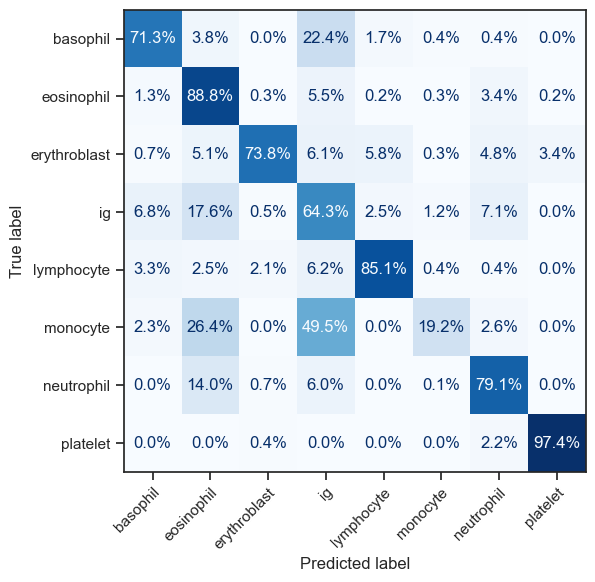

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

# modelin confusion matrisini gösterme
fig, axes = plt.subplots(figsize=(10,6))
ConfusionMatrixDisplay.from_predictions(y_true=correct_labels,
                                        y_pred=predicted_labels,
                                        display_labels=grayscale_class_names,
                                        normalize="true",
                                        cmap="Blues",
                                        values_format=".1%",
                                        colorbar=False,
                                        ax=axes)
axes.set_xticklabels(labels=grayscale_class_names, rotation=45,
                     ha='right',
                     rotation_mode='anchor')
plt.show()

In [22]:
model.save(r"C:\Users\Gül\PycharmProjects\notebooks\75_grayscale_model.keras")